In [57]:
from tqdm import tqdm
import argparse
import os
import random

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch

from model import Net
from utils import ConfigS, ConfigL, download_weights
from tqdm import tqdm



In [58]:
# Set the required values
checkpoint_name = 'model.pt'
size = 'S'
res_path = './data/result/prediction'
temperature = 1.0

config = ConfigL() if size.upper() == 'L' else ConfigS()


In [59]:
# set seed
random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)
torch.backends.cudnn.deterministic = True




In [60]:
is_cuda = torch.cuda.is_available()
device = 'cuda' if is_cuda else 'cpu'


In [43]:
def predict(img_path,size,checkpoint_name,res_path,temperature,device,config):

    ckp_path = os.path.join(config.weights_dir, checkpoint_name)

    assert os.path.isfile(img_path), 'Image does not exist'

    if not os.path.exists(res_path):
        os.makedirs(res_path)

    img = Image.open(img_path)

    model = Net(
        clip_model=config.clip_model,
        text_model=config.text_model,
        ep_len=config.ep_len,
        num_layers=config.num_layers, 
        n_heads=config.n_heads, 
        forward_expansion=config.forward_expansion, 
        dropout=config.dropout, 
        max_len=config.max_len,
        device=device
    )

    if not os.path.exists(config.weights_dir):
        os.makedirs(config.weights_dir)

    if not os.path.isfile(ckp_path):
        download_weights(ckp_path, size)

    checkpoint = torch.load(ckp_path, map_location=device)
    model.load_state_dict(checkpoint)

    model.eval()

    with torch.no_grad():
        caption, _ = model(img, temperature)    
    print(caption)
    plt.imshow(img)
    #plt.title(caption)
    plt.axis('off')

    # Display the image with the caption
    plt.show()

    img_save_path = f'{os.path.split(img_path)[-1].split(".")[0]}-R{size.upper()}.jpg'
    plt.savefig(os.path.join(res_path, img_save_path), bbox_inches='tight')

    plt.clf()
    plt.close()

    #print('Generated Caption: "{}"'.format(caption))


The man in the blue shirt is riding a bike.


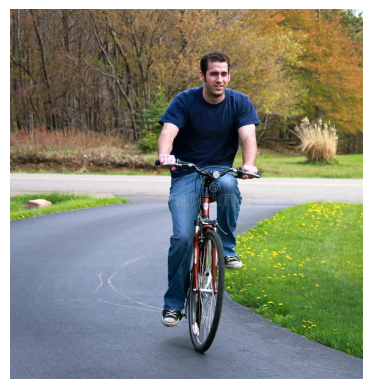

In [22]:
img_path = '/home/vanshporwal/Project/Image Captioning/image.jpeg'  # Provide the path to the image here
predict(img_path,size,checkpoint_name,res_path,temperature,device,config)

One dog is running through a field.


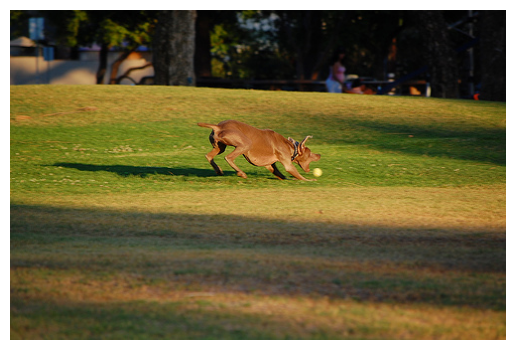

In [9]:
img_path = '/home/vanshporwal/Project/Image Captioning/image1.jpg'  # Provide the path to the image here
predict(img_path,size,checkpoint_name,res_path,temperature,device,config)

Children are playing on a beach.


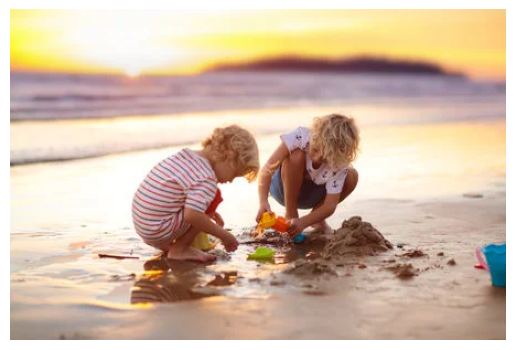

In [28]:
img_path = '/home/vanshporwal/Project/Image Captioning/image2.webp'  # Provide the path to the image here
predict(img_path,size,checkpoint_name,res_path,temperature,device,config)

"Lady in red dress dancing on the street. "


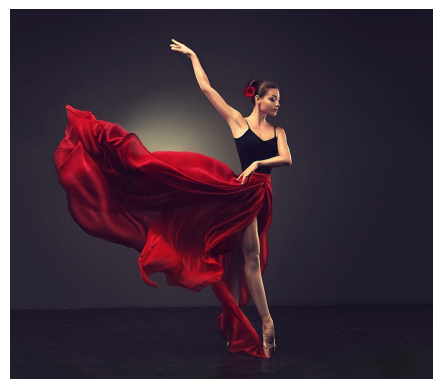

In [29]:
img_path = '/home/vanshporwal/Project/Image Captioning/image3.jpeg'  # Provide the path to the image here
predict(img_path,size,checkpoint_name,res_path,temperature,device,config)

There are two dogs running in a field.


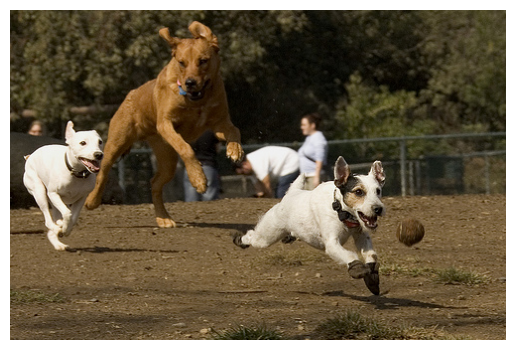

In [11]:
img_path = '/home/vanshporwal/Project/Image Captioning/mm4.jpg'  # Provide the path to the image here
predict(img_path,size,checkpoint_name,res_path,temperature,device,config)

# Getting the BLEU score

In [44]:
def predict(img_path,size,checkpoint_name,res_path,temperature,device,config):

    ckp_path = os.path.join(config.weights_dir, checkpoint_name)

    assert os.path.isfile(img_path), 'Image does not exist'

    if not os.path.exists(res_path):
        os.makedirs(res_path)

    img = Image.open(img_path)

    model = Net(
        clip_model=config.clip_model,
        text_model=config.text_model,
        ep_len=config.ep_len,
        num_layers=config.num_layers, 
        n_heads=config.n_heads, 
        forward_expansion=config.forward_expansion, 
        dropout=config.dropout, 
        max_len=config.max_len,
        device=device
    )

    if not os.path.exists(config.weights_dir):
        os.makedirs(config.weights_dir)

    if not os.path.isfile(ckp_path):
        download_weights(ckp_path, size)

    checkpoint = torch.load(ckp_path, map_location=device)
    model.load_state_dict(checkpoint)

    model.eval()

    with torch.no_grad():
        caption, _ = model(img, temperature)   
    return caption
    

In [45]:
def generate_and_store_captions(img_folder, captions_txt_path, size, checkpoint_name, res_path, temperature, device, config):
    # List all files in the image directory
    img_files = os.listdir(img_folder)

    # Initialize an empty list to store the captions
    captions_list = []

    # Load ground truth captions
    with open(captions_txt_path, 'r') as f:
        ground_truth_captions = f.readlines()

    # Convert ground truth captions into a dictionary
    gt_captions_dict = {}
    for line in ground_truth_captions:
        img_name, _, caption_text = line.strip().split('|')
        gt_captions_dict[img_name] = caption_text

    # Counter for the number of images processed
    img_count = 0

    # Iterate over all image files
    for img_file in tqdm(img_files, desc="Generating captions"):
        # Ensure the file is an image
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Full path to the image file
        img_path = os.path.join(img_folder, img_file)

        # Generate the caption using your `predict` function
        caption = predict(img_path, size, checkpoint_name, res_path, temperature, device, config)

        # Check if the generated caption is not just "."
        if caption.strip() == ".":
            continue

        # Get the corresponding ground truth caption
        gt_caption = gt_captions_dict.get(img_file, None)

        # If there is a ground truth caption, append to the list
        if gt_caption is not None:
            captions_list.append([caption, gt_caption])

        # Increase the counter
        img_count += 1

        # Break the loop if the counter reaches 1000
        if img_count >= 1000:
            break
        #print("GT:",gt_caption,"Cap:",caption)
    # Return the list of captions
    return captions_list


In [ ]:
print("GT:",gt_caption,"Cap:",caption)

In [46]:
captions_dict = generate_and_store_captions('images', 'captions.txt', size, checkpoint_name, res_path, temperature, device, config)


Generating captions:  13%|█████▋                                       | 1030/8091 [1:14:29<8:30:42,  4.34s/it]


In [54]:
with open('captions_new.txt', 'w') as f:
    for caption in captions_dict:
        f.write("%s\n" % caption)

In [6]:
import ast
from nltk.translate.bleu_score import corpus_bleu

# Read file
with open('captions_new.txt', 'r') as f:
    lines = f.readlines()

# Evaluate lines as Python lists and append them to `captions_list`
captions_list = [ast.literal_eval(line) for line in lines if line.strip()]

# Extract generated captions and ground truth captions
generated_captions = [caption_pair[0] for caption_pair in captions_list]
ground_truth_captions = [[caption_pair[1]] for caption_pair in captions_list]  # note the double brackets

# Compute BLEU scores
bleu_1 = corpus_bleu(ground_truth_captions, generated_captions, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(ground_truth_captions, generated_captions, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu(ground_truth_captions, generated_captions, weights=(0.3, 0.3, 0.3, 0))
bleu_4 = corpus_bleu(ground_truth_captions, generated_captions, weights=(0.25, 0.25, 0.25, 0.25))

# Print BLEU scores
print('BLEU-1: %f' % bleu_1)
print('BLEU-2: %f' % bleu_2)
print('BLEU-3: %f' % bleu_3)
print('BLEU-4: %f' % bleu_4)


BLEU-1: 0.612064
BLEU-2: 0.460623
BLEU-3: 0.388736
BLEU-4: 0.287751
